In [ ]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import shap
import re
# Modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
import warnings

In [2]:
df = pd.read_parquet('../artifacts/train.parquet')

In [3]:
df.head()

,repo,issue_id,issue_number,pull_request,events,text_size,content,usernames
0,CrowdStrike/psfalcon,942442053,59,None,"[{'action': 'opened', 'author': 'bk-cs', 'comm...",314,<issue_start><issue_comment>Title: 'CloneId' d...,"[""bk-cs""]"
1,NixOS/nixpkgs,114265976,10717,"{'number': 10717.0, 'repo': 'nixpkgs', 'user_l...","[{'action': 'opened', 'author': 'richardipsum'...",699,<issue_start><issue_comment>Title: Update clia...,"[""jagajaga"", ""richardipsum""]"
2,rosalindfranklininstitute/rfi-file-monitor,835865359,185,"{'number': 185.0, 'repo': 'rfi-file-monitor', ...","[{'action': 'opened', 'author': 'tschoonj', 'c...",502,<issue_start><issue_comment>Title: Allow engin...,"[""tschoonj""]"
3,19wu/19wu,85773196,642,None,"[{'action': 'opened', 'author': 'angelfan', 'c...",240,<issue_start><issue_comment>Title: error\nuser...,"[""angelfan"", ""Kevinqingyu""]"
4,withastro/astro,1092870321,2300,"{'number': 2300.0, 'repo': 'astro', 'user_logi...","[{'action': 'opened', 'author': 'moritzlaube',...",711,<issue_start><issue_comment>Title: Update svel...,"[""moritzlaube"", ""matthewp""]"


In [4]:
df['content'][0]

"<issue_start><issue_comment>Title: 'CloneId' doesn't work with New-Falcon...Policy\nusername_0: 'CloneId' is a query parameter for New-FalconFirewallPolicy, but not other policy types. Something is causing the `clone_id` value to be placed in the query field, rather than the body. This will be fixed in my next update.<issue_closed>\n<issue_comment>username_0: Fixed in [v2.1.0-alpha](https://github.com/CrowdStrike/psfalcon/releases/tag/v2.1.0-alpha)."

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195168 entries, 0 to 195167
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   repo          195168 non-null  object
 1   issue_id      195168 non-null  int64 
 2   issue_number  195168 non-null  int64 
 3   pull_request  63737 non-null   object
 4   events        195168 non-null  object
 5   text_size     195168 non-null  int64 
 6   content       195168 non-null  object
 7   usernames     195168 non-null  object
dtypes: int64(3), object(5)
memory usage: 11.9+ MB


In [6]:
#(drop pull requests) with values and keep those with None 
df = df[df["pull_request"].isna()].reset_index(drop=True)

#drop the column pull requests
df.drop(columns='pull_request',inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131431 entries, 0 to 131430
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   repo          131431 non-null  object
 1   issue_id      131431 non-null  int64 
 2   issue_number  131431 non-null  int64 
 3   events        131431 non-null  object
 4   text_size     131431 non-null  int64 
 5   content       131431 non-null  object
 6   usernames     131431 non-null  object
dtypes: int64(3), object(4)
memory usage: 7.0+ MB


In [8]:
def parse_events_min(events):
    """
    Parse issue events into modeling features:
      - opened_at, closed_at, is_closed
      - lifecycle_hours
      - comment_count
      - first_response_minutes
      - participants_count
    """
    opened_at = None
    closed_at = None
    first_comment_at = None
    first_responder = None
    comment_count = 0
    participants = set()


    # Accept list/tuple/np.ndarray of event dicts
    if isinstance(events, np.ndarray):
        events = events.tolist()
    if not isinstance(events, (list, tuple)):
        return {
            "opened_at": None,
            "closed_at": None,
            "is_closed": False,
            "lifecycle_hours": None,
            "comment_count": 0,
            "first_response_minutes": None,
            "participants_count": 0,
        }

    for ev in events:
        ev_type = (ev.get("type") or "").lower()       # 'issue' | 'comment' | ...
        action  = (ev.get("action") or "").lower()     # 'opened' | 'closed' | 'created' ...
        author  = ev.get("author")
        dt      = pd.to_datetime(ev.get("datetime"), utc=True, errors="coerce")

        if author:
            participants.add(author)

        if ev_type == "issue" and action == "opened" and opened_at is None:
            opened_at = dt
        elif ev_type == "issue" and action == "closed" and closed_at is None:
            closed_at = dt
        elif ev_type == "comment":
            comment_count += 1
            if first_comment_at is None:
                first_comment_at = dt
                first_responder = author

    is_closed = closed_at is not None

    lifecycle_hours = (
        (closed_at - opened_at).total_seconds() / 3600.0
        if opened_at is not None and closed_at is not None
        else None
    )

    first_response_minutes = (
        (first_comment_at - opened_at).total_seconds() / 60.0
        if opened_at is not None and first_comment_at is not None
        else None
    )

    return {
        "opened_at": opened_at,
        "closed_at": closed_at,
        "is_closed": is_closed,
        "lifecycle_hours": lifecycle_hours,
        "comment_count": int(comment_count),
        "first_response_minutes": first_response_minutes,
        "participants_count": int(len(participants)),
    }


In [9]:
# Expand features from events
fe = df["events"].apply(parse_events_min).apply(pd.Series)

# Join back
df = pd.concat([df.drop(columns=["opened_at","closed_at","is_closed",
                                  "lifecycle_hours","comment_count",
                                  "first_response_minutes","participants_count"], errors="ignore"),
                 fe], axis=1)

In [11]:
#filter for only rows where df is_close == True
df_model = df[
    (df["is_closed"] == True) & 
    (df["lifecycle_hours"].notna())
].copy()

In [12]:
#create new col for missing first response 
df_model["first_response_missing"] = df_model["first_response_minutes"].isna().astype(int)
df_model["first_response_minutes"].fillna(-1, inplace=True)


/var/folders/nl/4plg4prn2w39wf8d2gclsmqc0000gn/T/ipykernel_534/2976619631.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_model["first_response_minutes"].fillna(-1, inplace=True)


In [13]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93409 entries, 0 to 131430
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   repo                    93409 non-null  object             
 1   issue_id                93409 non-null  int64              
 2   issue_number            93409 non-null  int64              
 3   events                  93409 non-null  object             
 4   text_size               93409 non-null  int64              
 5   content                 93409 non-null  object             
 6   usernames               93409 non-null  object             
 7   opened_at               93409 non-null  datetime64[ns, UTC]
 8   closed_at               93409 non-null  datetime64[ns, UTC]
 9   is_closed               93409 non-null  bool               
 10  lifecycle_hours         93409 non-null  float64            
 11  comment_count           93409 non-null  int64

In [14]:
#clean up content column
def clean_content(text: str) -> str:
    if not isinstance(text, str):
        return ""
    # remove special tokens like <issue_start>, <issue_comment>, <issue_closed>
    text = re.sub(r"<[^>]+>", " ", text)
    # remove usernames like @username_123
    text = re.sub(r"@\w+", " ", text)
    # remove issue/bug IDs like #TRAC123 or #1234
    text = re.sub(r"#\w+", " ", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply to dataset
df_model["content_clean"] = df_model["content"].apply(clean_content)

In [15]:

TITLE_RE = re.compile(r"(?i)\btitle:\s*(.+?)\s*(?=username_\d+:|$)")
SPEAKER_RE = re.compile(r"\busername_\d+:\s*")

def split_title_body(text: str):
    if not isinstance(text, str) or not text.strip():
        return "", ""
    # 1) extract title (text after "Title:" up to next speaker or end)
    m = TITLE_RE.search(text)
    title = m.group(1).strip() if m else ""
    # 2) remove title segment (including the "Title:" token) from the body
    body = TITLE_RE.sub(" ", text) if m else text
    # 3) remove speaker tags like "username_1:" from body
    body = SPEAKER_RE.sub(" ", body)
    # 4) collapse whitespace
    body = re.sub(r"\s+", " ", body).strip()
    return title, body

# Apply
df_model[["issue_title", "content_body"]] = df_model["content_clean"].apply(
    lambda t: pd.Series(split_title_body(t))
)


In [16]:
# 3-class version
bins   = [0, 24, 168, float("inf")]
labels = ["Short", "Medium", "Long"]

df_model["resolution_class"] = pd.cut(
    df_model["lifecycle_hours"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

print(df_model["resolution_class"].value_counts(normalize=True).mul(100).round(2))


resolution_class
Long      49.12
Short     30.67
Medium    20.22
Name: proportion, dtype: float64


In [17]:
# Drop rows where resolution_class is NaN
df_model = df_model.dropna(subset=["resolution_class"]).copy()

In [18]:
def drop_negatives(df, col):
    return df[df[col] >= 0]

# Usage
df_model = drop_negatives(df_model, "lifecycle_hours")

In [19]:
X_cols = [
    #'issue_title',
    "text_size", 
    "comment_count", 
    "participants_count", 
    "first_response_minutes", 
    "first_response_missing"
]

#### Preparing X and Y variables

In [88]:
# --- 0) pick columns from your original df ---
num_cols = ["text_size","comment_count","participants_count","first_response_minutes",]
X_df = df_model[num_cols].copy()                # IMPORTANT: use the DataFrame, not a prior array
y    = df_model["resolution_class"].copy()      # adjust target name if needed

#### Create an Evaluate Function to give all metrics after model Training

In [89]:
def eval_metrics(y_true, y_pred, le):
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    f1_wt = f1_score(y_true, y_pred, average="weighted")
    prec_ma = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_ma  = recall_score(y_true, y_pred, average="macro", zero_division=0)

    # per-class metrics
    classes = list(le.classes_)  # e.g., ["Short","Medium","Long"]
    p_cls, r_cls, f_cls, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=np.arange(len(classes)), zero_division=0
    )
    # Find indices for "Long" and "Short" if present
    idx_long  = classes.index("Long")  if "Long"  in classes else None
    idx_short = classes.index("Short") if "Short" in classes else None
    recall_long     = r_cls[idx_long]  if idx_long  is not None else np.nan
    precision_short = p_cls[idx_short] if idx_short is not None else np.nan

    return {
        "acc": acc, "f1_macro": f1_ma, "f1_weighted": f1_wt,
        "precision_macro": prec_ma, "recall_macro": rec_ma,
        "recall_long": recall_long, "precision_short": precision_short
    }

In [90]:
# --- 1) scale ---
preprocessor = ColumnTransformer([("num", RobustScaler(), num_cols)])
X_scaled = preprocessor.fit_transform(X_df)   # -> shape (n_samples, 5)

# --- 2) split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3) encode y AFTER split (avoid leakage/mismatch) ---
le = LabelEncoder()
y_train_cls = le.fit_transform(y_train)
y_test_cls  = le.transform(y_test)

LogisticRegression
Train | Acc: 0.607  F1-macro: 0.445  Prec-macro: 0.429  Rec-macro: 0.507  Recall(Long): 0.759  Precision(Short): 0.532
Test  | Acc: 0.606  F1-macro: 0.446  Prec-macro: 0.732  Rec-macro: 0.507  Recall(Long): 0.757  Precision(Short): 0.534
----------------------------------------------------------------------


/Users/obinnadinneya/miniconda3/envs/venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC
Train | Acc: 0.607  F1-macro: 0.447  Prec-macro: 0.428  Rec-macro: 0.513  Recall(Long): 0.729  Precision(Short): 0.513
Test  | Acc: 0.607  F1-macro: 0.447  Prec-macro: 0.669  Rec-macro: 0.514  Recall(Long): 0.727  Precision(Short): 0.512
----------------------------------------------------------------------
KNN
Train | Acc: 0.727  F1-macro: 0.688  Prec-macro: 0.709  Rec-macro: 0.677  Recall(Long): 0.847  Precision(Short): 0.760
Test  | Acc: 0.618  F1-macro: 0.562  Prec-macro: 0.575  Rec-macro: 0.557  Recall(Long): 0.758  Precision(Short): 0.631
----------------------------------------------------------------------
RandomForest
Train | Acc: 0.955  F1-macro: 0.951  Prec-macro: 0.957  Rec-macro: 0.946  Recall(Long): 0.976  Precision(Short): 0.954
Test  | Acc: 0.625  F1-macro: 0.573  Prec-macro: 0.582  Rec-macro: 0.572  Recall(Long): 0.731  Precision(Short): 0.602
----------------------------------------------------------------------


/Users/obinnadinneya/miniconda3/envs/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [12:40:44] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_abwcuua5oq/croot/xgboost-split_1749630928197/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier
Train | Acc: 0.693  F1-macro: 0.630  Prec-macro: 0.694  Rec-macro: 0.624  Recall(Long): 0.817  Precision(Short): 0.657
Test  | Acc: 0.662  F1-macro: 0.595  Prec-macro: 0.654  Rec-macro: 0.592  Recall(Long): 0.792  Precision(Short): 0.624
----------------------------------------------------------------------
CatBoost
Train | Acc: 0.685  F1-macro: 0.622  Prec-macro: 0.683  Rec-macro: 0.616  Recall(Long): 0.816  Precision(Short): 0.655
Test  | Acc: 0.661  F1-macro: 0.595  Prec-macro: 0.653  Rec-macro: 0.591  Recall(Long): 0.796  Precision(Short): 0.626
----------------------------------------------------------------------
AdaBoost
Train | Acc: 0.649  F1-macro: 0.600  Prec-macro: 0.630  Rec-macro: 0.601  Recall(Long): 0.708  Precision(Short): 0.589
Test  | Acc: 0.644  F1-macro: 0.594  Prec-macro: 0.626  Rec-macro: 0.596  Recall(Long): 0.704  Precision(Short): 0.580
----------------------------------------------------------------------

Best model by F1-macro: CatBoost -> {'ac

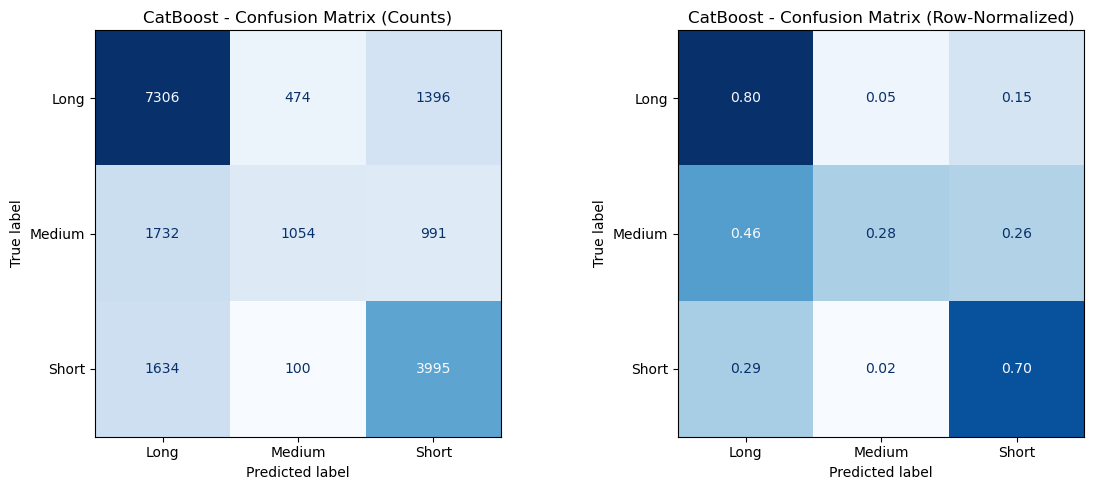


Detailed classification report (best model):
              precision    recall  f1-score   support

        Long       0.68      0.80      0.74      9176
      Medium       0.65      0.28      0.39      3777
       Short       0.63      0.70      0.66      5729

    accuracy                           0.66     18682
   macro avg       0.65      0.59      0.60     18682
weighted avg       0.66      0.66      0.64     18682



In [91]:
# --- 4) define models ---
models = {
    "LogisticRegression": LogisticRegression(),
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
    "CatBoost": CatBoostClassifier(verbose=False),
    "AdaBoost": AdaBoostClassifier()
}

# --- 5) evaluation loop ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train_cls)

    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)

    tr = eval_metrics(y_train_cls, y_tr_pred, le)
    te = eval_metrics(y_test_cls,  y_te_pred,  le)

    results[name] = te

    print(name)
    print(f"Train | Acc: {tr['acc']:.3f}  F1-macro: {tr['f1_macro']:.3f}  "
          f"Prec-macro: {tr['precision_macro']:.3f}  Rec-macro: {tr['recall_macro']:.3f}  "
          f"Recall(Long): {tr['recall_long']:.3f}  Precision(Short): {tr['precision_short']:.3f}")
    print(f"Test  | Acc: {te['acc']:.3f}  F1-macro: {te['f1_macro']:.3f}  "
          f"Prec-macro: {te['precision_macro']:.3f}  Rec-macro: {te['recall_macro']:.3f}  "
          f"Recall(Long): {te['recall_long']:.3f}  Precision(Short): {te['precision_short']:.3f}")
    print("-" * 70)

# --- 6) pick best model ---
best_name = max(results, key=lambda k: results[k]["f1_macro"])
best_model = models[best_name]
print(f"\nBest model by F1-macro: {best_name} -> {results[best_name]}")

# --- 7) confusion matrix + report ---
y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test_cls, y_pred_best, labels=np.arange(len(le.classes_)))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title(f"{best_name} - Confusion Matrix (Counts)")

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
ConfusionMatrixDisplay(cm_norm, display_labels=le.classes_).plot(
    ax=ax[1], cmap="Blues", values_format=".2f", colorbar=False
)
ax[1].set_title(f"{best_name} - Confusion Matrix (Row-Normalized)")
plt.tight_layout()
plt.show()

print("\nDetailed classification report (best model):")
print(classification_report(
    y_test_cls, 
    y_pred_best, 
    target_names=[str(c) for c in le.classes_], 
    zero_division=0
))




### SHAP EXPLANATION

sv.values.shape: (18682, 4, 3)
sv.base_values.shape: (18682, 3)


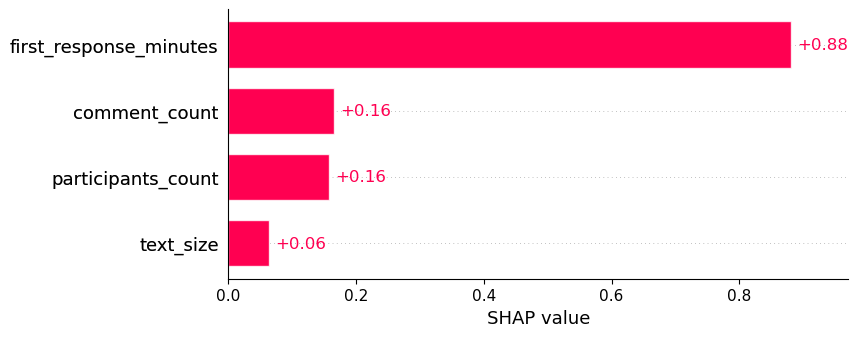

In [92]:
# X_test_df MUST be a DataFrame with your 4 feature names
# num_cols = ["text_size","comment_count","participants_count","first_response_minutes"]
X_test_df = pd.DataFrame(X_test, columns=num_cols)


# 1) Build explainer & explanation (do NOT pass y)
explainer = shap.TreeExplainer(best_model)
sv = explainer(X_test_df)   # sv is a shap.Explanation

print("sv.values.shape:", sv.values.shape)       # expect (n_samples, 4, 3) for 3 classes
print("sv.base_values.shape:", sv.base_values.shape)

# 2) GLOBAL importance (aggregate over samples and classes)
glob = np.abs(sv.values).mean(axis=(0, 2))       # -> (4,)
shap.plots.bar(
    shap.Explanation(values=glob, base_values=0, data=None, feature_names=num_cols)
)

# 3) LOCAL force plot for one row & one class
i = 0                # choose a sample index (plain int)
k = 0                # choose a class index (plain int)

row_vals = sv.values[i, :, k]                    # (4,)
# base_values can be shape (n_samples, n_classes) or (n_classes,)
base = sv.base_values[i, k] if sv.base_values.ndim == 2 else sv.base_values[k]
row_data = X_test_df.iloc[i].values             # (4,)

row_expl = shap.Explanation(
    values=row_vals,
    base_values=base,
    data=row_data,
    feature_names=num_cols
)
shap.plots.force(row_expl)



The SHAP feature importance plot shows that the model’s predictions are dominated by first_response_minutes, followed by comment_count and participants_count, with text_size having only a minor effect. This means the model relies most on response speed, while ticket length contributes very little to prediction decisions.